# **Progetto di ML – Predizione del Reddito Annuo**
In questo notebook viene implementata una pipeline di Machine Learning sul dataset "Adult Census Income" (disponibile su Kaggle) per prevedere se il reddito annuo di una persona è ≤50K o >50K.

Il dataset originale contiene **48.842** campioni e viene suddiviso in:
- **Training set:** 38.842 campioni (prima del bilanciamento)  
- **Test set:** 10.000 campioni



## **Pipeline:**
### **1. Analisi Esplorativa dei Dati (EDA):**
    - Caricamento del dataset
    - Visualizzazione delle prime righe, statistiche descrittive e informazioni generali
    - Analisi dei valori mancanti
    - Analisi della distribuzione delle feature (numeriche e categoriche)
    - Visualizzazione dello sbilanciamento della label

### **2. Pre-elaborazione dei Dati:**
    - Sostituzione dei “?” con NaN e imputazione (mediana per numeriche, moda per categoriche)
    - Rimozione delle feature native_country, race,
      capital_gain, capital_loss e fnlwgt
    - Conversione della label in valori binari

### **3. Feature Engineering:**
    - Binning delle feature numeriche
    - One-Hot Encoding di tutte le feature categoriche

### **4. Bilanciamento del Dataset:**
    - Undersampling della classe maggioritaria nel training set
    - Oversampling della classe minoritaria tramite SMOTE

### **5. Modellazione:**
    - Addestramento di 5 modelli: Decision Tree, Random Forest, Logistic Regression, K-Nearest Neighbors e Naïve Bayes
    - Valutazione delle prestazioni tramite confusion matrix e accuracy
    - Ensemble finale tramite majority vote


## **Importazione delle Librerie e Configurazioni Iniziali**

In [ ]:
# Importazione delle librerie e configurazioni iniziali
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="whitegrid", palette="muted", font_scale=1.1)

from imblearn.over_sampling import SMOTE

# Importazione dei modelli e metriche
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import BernoulliNB

## **Funzione per il Caricamento del Dataset**

La funzione `load_data` legge il file CSV, assegna le intestazioni e rimuove eventuali spazi bianchi.

In [ ]:
def load_data(filename):
    """
    Legge il file CSV, assegna le intestazioni e pulisce gli spazi extra.
    """
    headers = ["age", "workclass", "fnlwgt", "education", "education_num", "marital_status",
               "occupation", "relationship", "race", "sex", "capital_gain", "capital_loss",
               "hours_per_week", "native_country", "label"]
    df = pd.read_csv(filename, names=headers, skipinitialspace=True)
    # Rimuove spazi iniziali/finali nelle stringhe
    for col in df.select_dtypes(include=['object']).columns:
        df[col] = df[col].str.strip()
    return df

train_df = load_data('census-income.data.csv')
test_df  = load_data('census-income.test.csv')

# Visualizziamo le prime righe del dataset di training
print("Dataset di Training - Prime righe:")
display(train_df.head())

Dataset di Training - Prime righe:


,age,workclass,fnlwgt,education,education_num,marital_status,occupation,relationship,race,sex,capital_gain,capital_loss,hours_per_week,native_country,label
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


## **Analisi Esplorativa dei Dati (EDA)**

- Analisi dei valori mancanti
- Analisi della distribuzione delle feature (numeriche e categoriche)
- Visualizzazione dello sbilanciamento della label

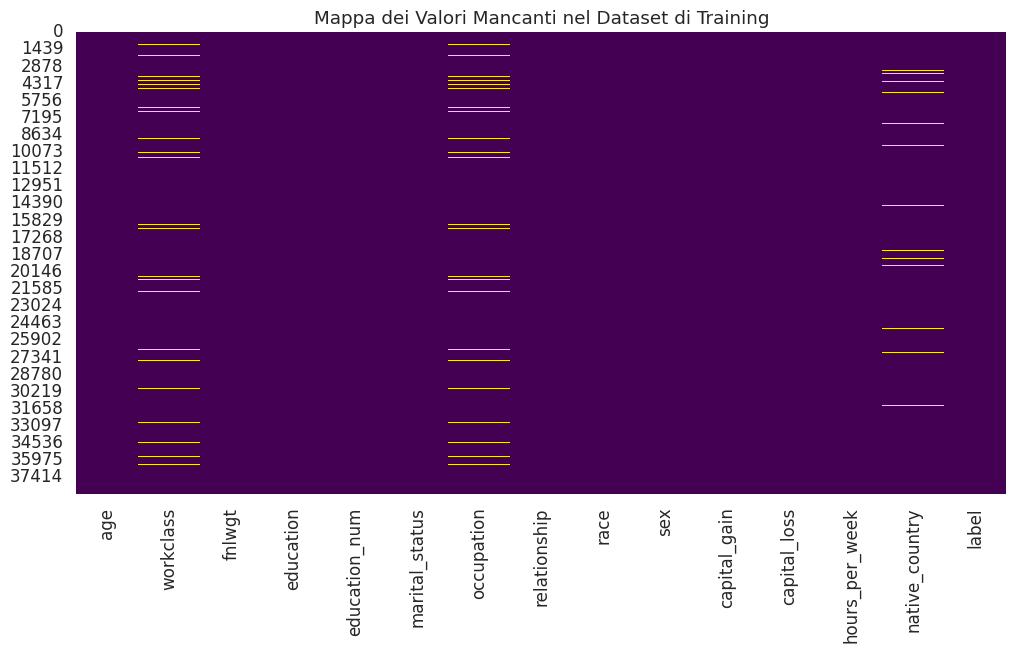

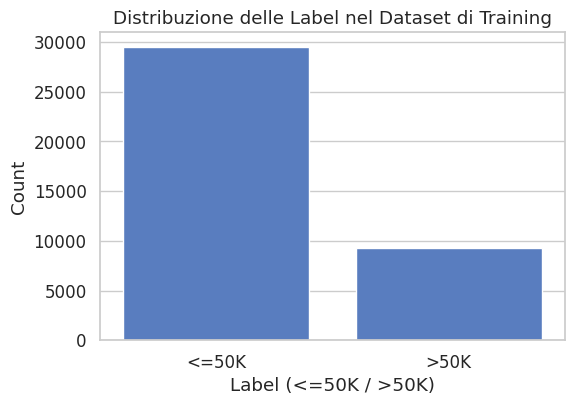

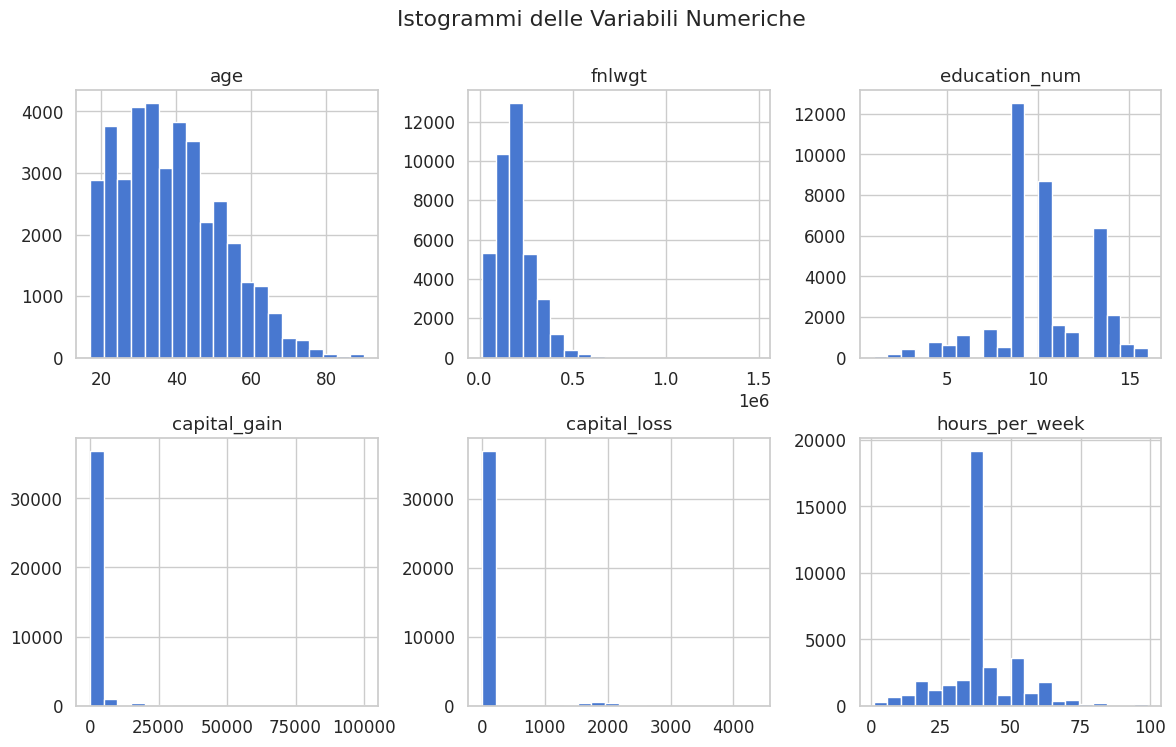

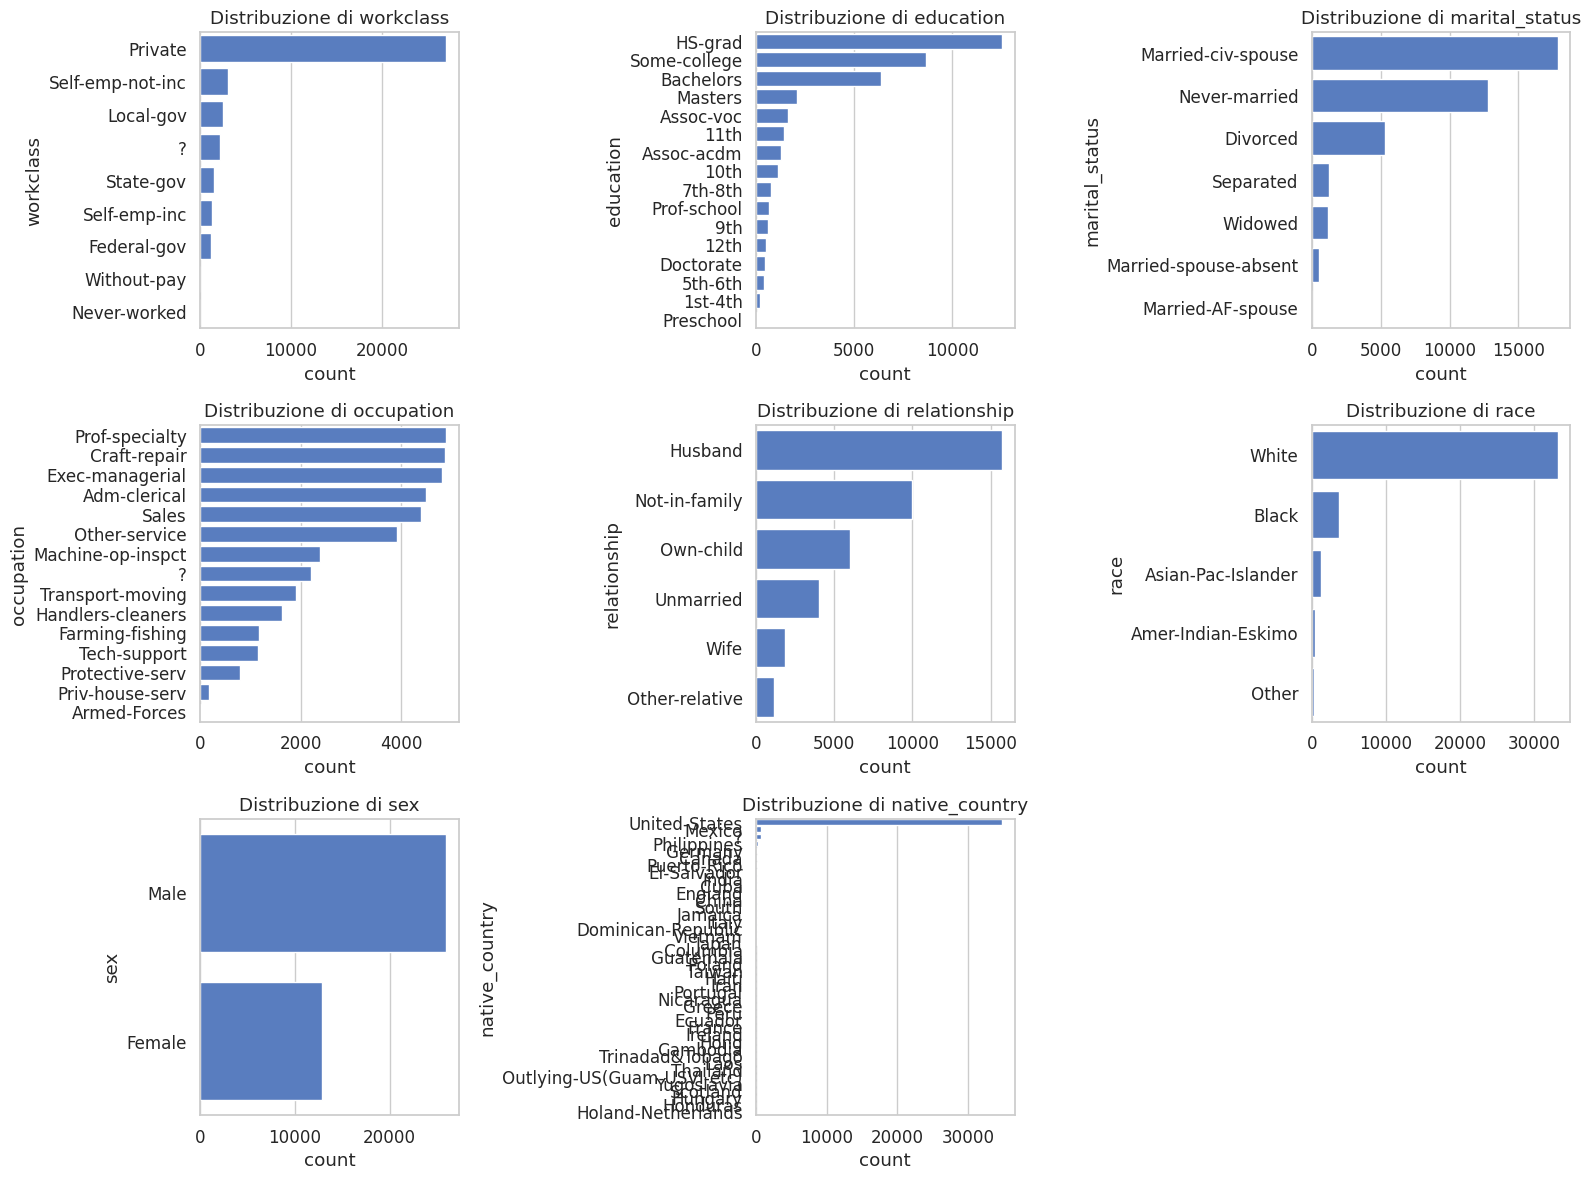

In [ ]:
# Visualizzazione dei valori mancanti
df_missing = train_df.replace('?', np.nan)
plt.figure(figsize=(12, 6))
sns.heatmap(df_missing.isnull(), cbar=False, cmap="viridis")
plt.title("Mappa dei Valori Mancanti nel Dataset di Training")
plt.show()

# Distribuzione della label
# Uniformazione delle etichette rimuovendo i punti finali
train_df['label'] = train_df['label'].str.rstrip('.')
plt.figure(figsize=(6,4))
sns.countplot(x='label', data=train_df, order=train_df['label'].value_counts().index)
plt.title("Distribuzione delle Label nel Dataset di Training")
plt.xlabel("Label (<=50K / >50K)")
plt.ylabel("Count")
plt.show()

# Istogrammi delle variabili numeriche
numeric_cols = ['age', 'fnlwgt', 'education_num', 'capital_gain', 'capital_loss', 'hours_per_week']
train_df[numeric_cols] = train_df[numeric_cols].replace('?', np.nan).astype(float)
train_df[numeric_cols].hist(bins=20, figsize=(14,8), layout=(2, 3))
plt.suptitle("Istogrammi delle Variabili Numeriche")
plt.show()

# Countplot per alcune variabili categoriche (inclusi "race" e "native_country" che verranno successivamente rimossi)
categorical_cols = ['workclass', 'education', 'marital_status', 'occupation', 'relationship', 'race', 'sex', 'native_country']
plt.figure(figsize=(16, 12))
for i, col in enumerate(categorical_cols, 1):
    plt.subplot(3, 3, i)
    sns.countplot(y=col, data=train_df, order=train_df[col].value_counts().index)
    plt.title(f"Distribuzione di {col}")
plt.tight_layout()
plt.show()

## **Pre-elaborazione dei Dati**
- Sostituzione dei “?” con NaN e imputazione (mediana per numeriche, moda per categoriche)
- Rimozione delle feature native_country, race,
  capital_gain e capital_loss
- Conversione della label in valori binari


In [ ]:
def preprocess_data(train_df, test_df):
    """
    Pre-elabora i dati:
      - Sostituisce "?" con NaN e imputa:
           * variabili numeriche: mediana
           * variabili categoriche: moda
      - Rimuove le feature "native_country" e "race" per evitare bias
      - Rimuovere le feature capital_gain e capital_loss
      - Converte la label in valori binari
    """
    # Creiamo una copia dei DataFrame per evitare modifiche in-place
    train_df = train_df.copy()
    test_df = test_df.copy()

    # Sostituzione dei "?" con NaN
    train_df.replace('?', np.nan, inplace=True)
    test_df.replace('?', np.nan, inplace=True)

    # Definizione delle colonne numeriche e categoriche
    numeric_cols = ['age', 'education_num', 'hours_per_week']
    categorical_cols = ['workclass', 'education', 'marital_status', 'occupation', 'relationship', 'sex', 'label']

    # Imputazione per le variabili numeriche (mediana)
    for col in numeric_cols:
        train_df[col] = train_df[col].astype(float).fillna(train_df[col].median())
        test_df[col] = test_df[col].astype(float).fillna(test_df[col].median())

    # Imputazione per le variabili categoriche (moda)
    for col in categorical_cols:
        mode_value = train_df[col].mode()[0]
        train_df[col] = train_df[col].fillna(mode_value)
        test_df[col] = test_df[col].fillna(mode_value)

    # Rimozione delle feature, se presenti
    for col in ['native_country', 'race', 'capital_gain', 'capital_loss', 'fnlwgt']:
        if col in train_df.columns:
            train_df.drop(columns=[col], inplace=True)
        if col in test_df.columns:
            test_df.drop(columns=[col], inplace=True)

    # Conversione della label in valori binari
    label_mapping = {"<=50K": 0, ">50K": 1, "<=50K.": 0, ">50K.": 1}
    train_df['label'] = train_df['label'].map(label_mapping)
    test_df['label'] = test_df['label'].map(label_mapping)

    return train_df, test_df

# Applicazione della pre-elaborazione
train_df, test_df = preprocess_data(train_df, test_df)

# Verifica dei valori NaN dopo la pre-elaborazione
print("Valori NaN nel training set:")
print(train_df.isnull().sum())
print("\nValori NaN nel test set:")
print(test_df.isnull().sum())


Valori NaN nel training set:
age               0
workclass         0
education         0
education_num     0
marital_status    0
occupation        0
relationship      0
sex               0
hours_per_week    0
label             0
dtype: int64

Valori NaN nel test set:
age               0
workclass         0
education         0
education_num     0
marital_status    0
occupation        0
relationship      0
sex               0
hours_per_week    0
label             0
dtype: int64


## **Separazione delle Feature e della Label**


In [ ]:
def split_features_label(df):
    """
    Separa le feature dalla label.
    """
    X = df.drop(columns=['label'])
    y = df['label']
    return X, y

X_train, y_train = split_features_label(train_df)
X_test, y_test   = split_features_label(test_df)

## **Feature Engineering: Binning e One-Hot Encoding**

- Binning delle feature numeriche
- One-Hot Encoding di tutte le feature categoriche

In [ ]:
from sklearn.preprocessing import KBinsDiscretizer

def bin_numeric_features(X_train, X_test):
    """
    Esegue il binning delle feature numeriche utilizzando intervalli definiti sul training set.
    - 'age' e 'hours_per_week': bin fissi ogni 5 anni/ore.
    Restituisce DataFrame con feature binnate come categorie.
    """
    X_train_binned = X_train.copy()
    X_test_binned = X_test.copy()

    # Bin fisso per 'age' (0-100, step 5)
    age_bins = range(0, 105, 5)
    X_train_binned['age'] = pd.cut(X_train['age'], bins=age_bins, right=False).astype(str)
    X_test_binned['age'] = pd.cut(X_test['age'], bins=age_bins, right=False).astype(str)

    # Bin fisso per 'hours_per_week'
    hours_bins = range(0, 105, 5)
    X_train_binned['hours_per_week'] = pd.cut(X_train['hours_per_week'], bins=hours_bins, right=False).astype(str)
    X_test_binned['hours_per_week'] = pd.cut(X_test['hours_per_week'], bins=hours_bins, right=False).astype(str)

    return X_train_binned, X_test_binned

def feature_engineering(X_train, X_test):
    """
    Pipeline completa:
    1. Binning delle feature numeriche
    2. One-Hot Encoding di tutte le feature categoriche
    3. Allineamento delle colonne tra train e test
    """
    # Binning numerico
    X_train_binned, X_test_binned = bin_numeric_features(X_train, X_test)

    # One-Hot Encoding per tutte le feature categoriche
    X_train_encoded = pd.get_dummies(X_train_binned, drop_first=True)
    X_test_encoded = pd.get_dummies(X_test_binned, drop_first=True)

    # Allineamento colonne
    X_train_encoded, X_test_encoded = X_train_encoded.align(
        X_test_encoded,
        join='left',
        axis=1,
        fill_value=0
    )

    return X_train_encoded, X_test_encoded

# Applicazione del Feature Engineering
X_train_encoded, X_test_encoded = feature_engineering(X_train, X_test)

## **Bilanciamento del Dataset di Training**

Poiché il dataset è sbilanciato, è stato necessario ribilanciarlo. Per fare ciò si è scelto di utilizzare undersampling.

In [ ]:
def balance_data(X, y):
    """
    Bilancia il dataset di training utilizzando una combinazione di undersampling e oversampling (SMOTE).
    Prima si esegue un undersampling parziale della classe maggioritaria, poi si applica SMOTE per
    portare il dataset a bilanciamento completo.
    """
    # Uniamo le feature e la label in un DataFrame
    data = X.copy()
    data['label'] = y.values
    # Calcoliamo il numero di campioni per ogni classe
    class_counts = data['label'].value_counts()
    majority_label = class_counts.idxmax()
    minority_label = class_counts.idxmin()
    n_minority = class_counts.min()
    n_majority = class_counts.max()

    # Eseguiamo undersampling sulla classe maggioritaria per ridurla a un massimo di 2*n_minority campioni
    undersample_target = min(n_majority, 2 * n_minority)
    data_majority = data[data['label'] == majority_label].sample(n=undersample_target, random_state=0)
    data_minority = data[data['label'] == minority_label]
    data_combined = pd.concat([data_majority, data_minority]).sample(frac=1, random_state=0)  # shuffle

    X_temp = data_combined.drop(columns=['label'])
    y_temp = data_combined['label']

    # Applichiamo SMOTE per oversampling della classe minoritaria fino al bilanciamento
    smote = SMOTE(random_state=0)
    X_res, y_res = smote.fit_resample(X_temp, y_temp)
    # Convertiamo X_res in DataFrame per mantenere i nomi delle colonne
    X_res = pd.DataFrame(X_res, columns=X_temp.columns)
    return X_res, y_res

# Applicazione del bilanciamento sul dataset di training (sul dato già one-hot encoded)
X_train_balanced, y_train_balanced = balance_data(X_train_encoded, y_train)
print("Distribuzione classi dopo bilanciamento (training set):")
print(pd.Series(y_train_balanced).value_counts())

Distribuzione classi dopo bilanciamento (training set):
label
0    18660
1    18660
Name: count, dtype: int64


## **Addestramento e Valutazione dei Modelli**
Addestriamo i seguenti modelli:

- **Decision Tree**
- **Random Forest**
- **Logistic Regression**
- **K-Nearest Neighbors**
- **Naïve Bayes**

Per ciascun modello visualizziamo la confusion matrix e calcoliamo l’accuracy, il recall e la precision. Infine, viene effettuato un ensemble tramite majority vote.

=== Valutazione dei modelli individuali ===

--- Decision Tree ---


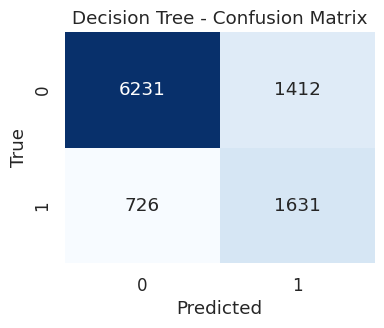

Accuracy: 0.79
Precision: 0.81
Recall: 0.79
F1 Score: 0.79

--- Random Forest ---


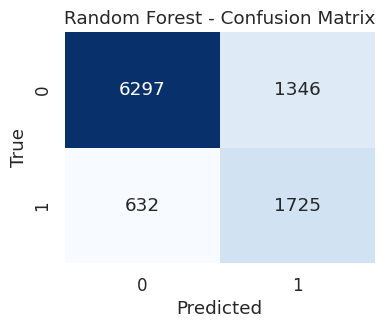

Accuracy: 0.80
Precision: 0.83
Recall: 0.80
F1 Score: 0.81

--- Logistic Regression ---


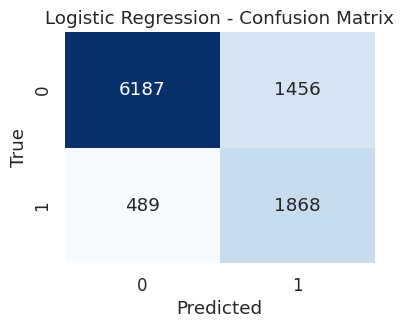

Accuracy: 0.81
Precision: 0.84
Recall: 0.81
F1 Score: 0.82

--- K-Nearest Neighbors ---


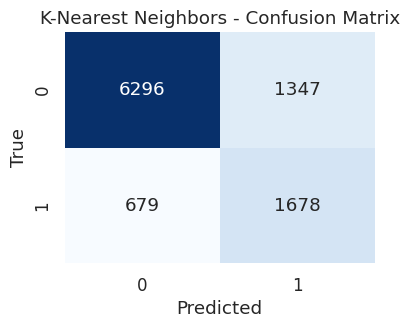

Accuracy: 0.80
Precision: 0.82
Recall: 0.80
F1 Score: 0.81

--- Naive Bayes ---


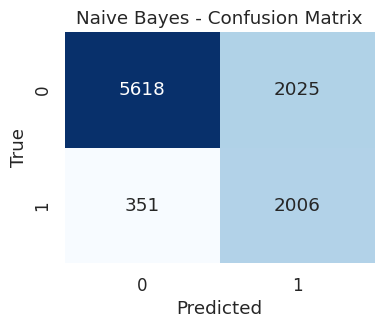

Accuracy: 0.76
Precision: 0.84
Recall: 0.76
F1 Score: 0.78

--- Ensemble Majority Vote (senza Naive Bayes) ---


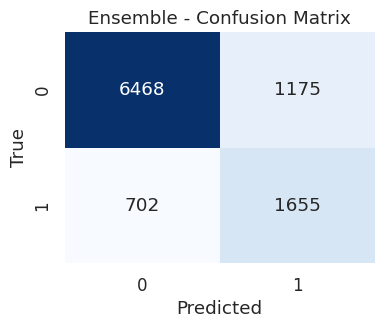

Ensemble Accuracy: 0.81
Ensemble Precision: 0.83
Ensemble Recall: 0.81
Ensemble F1 Score: 0.82


In [ ]:
def plot_confusion_matrix(y_true, y_pred, title="Confusion Matrix"):
    """
    Visualizza la confusion matrix come heatmap.
    """
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(4, 3))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
    plt.title(title)
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.show()

# Definizione dei modelli
models = {
    "Decision Tree": DecisionTreeClassifier(criterion='entropy', random_state=0),
    "Random Forest": RandomForestClassifier(criterion='entropy', random_state=0),
    "Logistic Regression": LogisticRegression(max_iter=1000, random_state=0),
    "K-Nearest Neighbors": KNeighborsClassifier(n_neighbors=5),
    "Naive Bayes": BernoulliNB()
}

predictions = {}
print("=== Valutazione dei modelli individuali ===\n")
for name, model in models.items():
    print(f"--- {name} ---")
    model.fit(X_train_balanced, y_train_balanced)
    y_pred = model.predict(X_test_encoded)
    plot_confusion_matrix(y_test, y_pred, title=f"{name} - Confusion Matrix")

    acc = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='weighted')
    recall = recall_score(y_test, y_pred, average='weighted')
    f1 = f1_score(y_test, y_pred, average='weighted')

    print(f"Accuracy: {acc:.2f}")
    print(f"Precision: {precision:.2f}")
    print(f"Recall: {recall:.2f}")
    print(f"F1 Score: {f1:.2f}\n")

    if name != "Naive Bayes":  # Escludiamo Naive Bayes
        predictions[name] = y_pred


def majority_vote(predictions_dict):
    """
    Combina le previsioni di più modelli tramite majority vote.
    Esclude il modello Naive Bayes.
    """
    preds = np.array(list(predictions_dict.values()))
    majority_votes = []
    for i in range(preds.shape[1]):
        vote = np.bincount(preds[:, i])
        majority_votes.append(np.argmax(vote))
    return np.array(majority_votes)

y_pred_ensemble = majority_vote(predictions)
print("--- Ensemble Majority Vote (senza Naive Bayes) ---")
plot_confusion_matrix(y_test, y_pred_ensemble, title="Ensemble - Confusion Matrix")

ensemble_acc = accuracy_score(y_test, y_pred_ensemble)
ensemble_precision = precision_score(y_test, y_pred_ensemble, average='weighted')
ensemble_recall = recall_score(y_test, y_pred_ensemble, average='weighted')
ensemble_f1 = f1_score(y_test, y_pred_ensemble, average='weighted')

print(f"Ensemble Accuracy: {ensemble_acc:.2f}")
print(f"Ensemble Precision: {ensemble_precision:.2f}")
print(f"Ensemble Recall: {ensemble_recall:.2f}")
print(f"Ensemble F1 Score: {ensemble_f1:.2f}")
